# TEST CMB ANGULAR POWER SPECTRA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

## 1. Load CAMB quantities

### CAMB Matter power spectrum

In [3]:
import camb

In [4]:
cosmo = FlatLambdaCDM(H0=67.5, Ob0=0.0483, Om0= 0.3174653243323745)

In [5]:
x = np.linspace(0.1, 10000, 21)
k = np.logspace(-5, 3, 3072)
TINY = np.finfo(0.).tiny

In [6]:
nz = 100

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

results = camb.get_background(pars)
xs = results.conformal_time(0) - results.tau_maxvis
x = np.linspace(0, xs, nz)
z = results.redshift_at_comoving_radial_distance(x)
k = np.logspace(-5, 3, 1024)

kh = k/(pars.H0/100)
pars.set_matter_power(redshifts=z, kmax=2*k[-1], nonlinear=True)
results = camb.get_results(pars)
kh, z, p = results.get_matter_power_spectrum(minkh=kh[0], maxkh=kh[-1], npoints=len(kh))

Note: redshifts have been re-sorted (earliest first)


In [7]:
pars.set_for_lmax(50000, lens_potential_accuracy=2)
pars.min_l = 1
results = camb.get_results(pars)
cl_camb = results.get_lens_potential_cls(50000)[:,0]

In [8]:
np.allclose(kh, k/(pars.H0/100))

True

In [9]:
p_geom = np.sqrt(p[:, None]*p[None, :])

## 2. The correlation function

In [10]:
import sys
sys.path.append("../../corfu")
import corfu

In [11]:
r_limb, xi_limb = corfu.ptoxi(k, p, q=0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, p_geom, q=0.5)

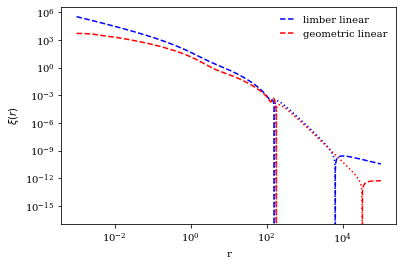

In [12]:
plt.figure(figsize=(6,4))
plt.loglog(r_limb, +xi_limb[0], '--b', label='limber linear')
plt.loglog(r_limb, -xi_limb[0], ':b')
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='geometric linear')
plt.loglog(r_geom, -xi_geom[0,0], ':r')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [13]:
sys.path.append("../")
from lens_filter import lensing_efficiency_cmb, lensing_efficiency, filter_convergence

* Redshift distribution of galaxies

In [14]:
xf = np.linspace(0., xs, 400)
zf = results.redshift_at_comoving_radial_distance(xf)

* CMB Lensing efficiency

In [15]:
q = lensing_efficiency_cmb(xf, xs)

* Convergence

In [16]:
fc = filter_convergence(xf, zf, q, cosmo)

## 4. Angular correlation function

In [17]:
theta = np.logspace(-4, np.log10(np.pi), 512)
theta_arcmin = np.degrees(theta)*60

In [18]:
w_limb = corfu.eqt(theta, (xf, fc*fc), (x, r_limb, xi_limb))

In [19]:
w_geom = corfu.uneqt(theta, (xf, fc), (xf, fc), (x, x, r_geom, xi_geom))

In [20]:
w_camb = corfu.cltow(cl_camb, theta)

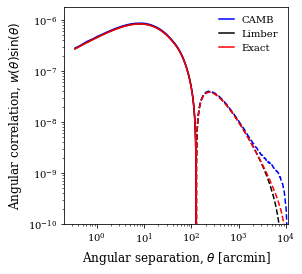

In [22]:
plt.figure(figsize=(4, 4))
plt.loglog(theta_arcmin, +1/2*w_camb*np.sin(theta), '-b', label='CAMB')
plt.loglog(theta_arcmin, -1/2*w_camb*np.sin(theta), '--b')
plt.loglog(theta_arcmin, +w_limb*np.sin(theta), '-k', label='Limber')
plt.loglog(theta_arcmin, -w_limb*np.sin(theta), '--k')
plt.loglog(theta_arcmin, +w_geom*np.sin(theta), '-r', label='Exact')
plt.loglog(theta_arcmin, -w_geom*np.sin(theta), '--r')
plt.xlim(None, 10800)
plt.ylim(1e-10, 1.8e-6)
plt.xlabel(r'Angular separation, $\theta$ [arcmin]', size=12)
plt.ylabel(r'Angular correlation, $w(\theta) \sin(\theta)$', size=12)
plt.legend(frameon=False)

# plt.savefig('plots/w_cmb.pdf', bbox_inches='tight')
plt.show()

## 5. Angular power spectra

In [23]:
l_limb, cl_limb = corfu.wtocl(theta, w_limb, lmax=2000)

In [24]:
l_geom, cl_geom = corfu.wtocl(theta, w_geom, lmax=2000)

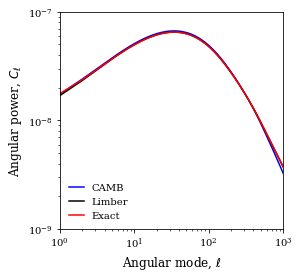

In [26]:
plt.figure(figsize=(4, 4))
plt.loglog(1/2*cl_camb, 'b', label='CAMB')
plt.loglog(cl_limb, 'k', label='Limber')
plt.loglog(cl_geom, 'r', label='Exact')
plt.xlim(1, 1e3)
plt.ylim(1e-9, 1e-7)
plt.xlabel(r'Angular mode, $\ell$', size=12)
plt.ylabel(r'Angular power, $C_{\ell}$', size=12)
plt.legend(frameon=False)

# plt.savefig('plots/cl_cmb.pdf', bbox_inches='tight')

plt.show()